# Accessing SHIFT Intake Catalog With R

This notebook shows how to load SHIFT data using the reticulate library in R.

Load the required R libraries and activate our Python Conda environment.

In [1]:
library(reticulate)
library(sf)
library(geojsonsf)
library(tidyverse)
use_condaenv("notebook")

Linking to GEOS 3.12.0, GDAL 3.7.0, PROJ 9.2.1; sf_use_s2() is TRUE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Load the required python libraries.

In [2]:
spu_path <- system.file("python", package = "/efs/SHIFT-Python-Utilities/")
py_run_string(paste0("import sys; sys.path.append('", spu_path, "')"))
shift_catalog <- import("shift_python_utilities.intake_shift.shift_catalog")
rxr <- import("rioxarray")
rio <- import("rasterio")
j <-import("json")

Open a reflectance file for a given flight. Then orthorectify and subset it using a shapefile.

In [3]:
date <- "20220224"
time <- "200332"
ortho <- r_to_py(TRUE)
subset <- r_to_py("/efs/SHIFT-Python-Utilities/shift_python_utilities/tests/test_data/intake_shift_shp/intake_shift_shp.shp")

ds = shift_catalog$SHIFTCatalog()$L2a(date=date, time=time, ortho=ortho, subset=subset)$read_chunked()
ds

<xarray.Dataset>
Dimensions:      (lat: 383, lon: 298, wavelength: 425)
Coordinates:
  * lat          (lat) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
  * lon          (lon) float64 2.348e+05 2.348e+05 ... 2.363e+05 2.363e+05
  * wavelength   (wavelength) float64 377.2 382.2 387.2 ... 2.496e+03 2.501e+03
    spatial_ref  int64 0
Data variables:
    reflectance  (lat, lon, wavelength) float32 -0.007509 -4.117e-05 ... nan nan
    elevation    (lat, lon) float32 -23.59 -23.19 -22.79 -22.54 ... nan nan nan
Attributes:
    description:                 AVIRIS-NG Measured Radiances in uW nm-1 cm-2...
    bands:                     425
    interleave:                bil
    data_type:                 4
    file_type:                 ENVI
    map_info:                  UTM, 1, 1, 224764.8, 3815937.6, 4.8, 4.8, 11, ...
    coordinate_system_string:  PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84"...
    wavelength:                [ 377.1956495  382.2056495  387.2156495  392.2...

Using the Xarray interface we can select data and load it as a numpy array by using the .values method. The numpy array can then be handled by R.

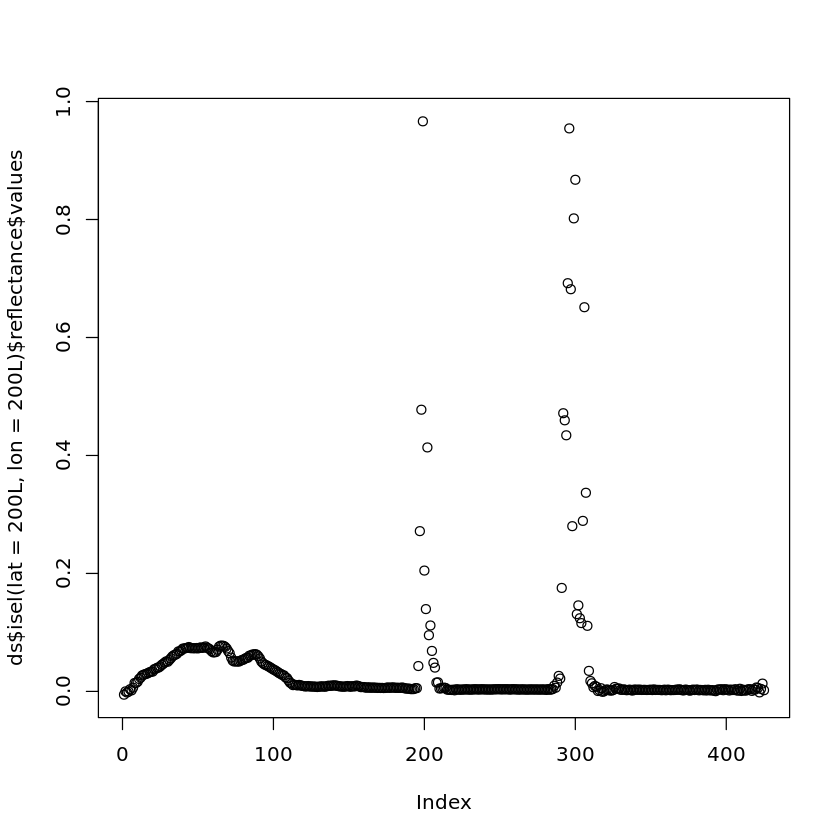

In [ ]:
plot(ds$isel(lat=200L, lon=200L)$reflectance$values)

Load the gridded data and write the CRS.

In [ ]:
ds = shift_catalog$SHIFTCatalog()$aviris_v1_gridded()$read_chunked()
crs <- ds$attrs['coordinate system string']
crs <- paste(unlist(crs), collapse=",")
ds <- ds$rio$write_crs(rio$CRS$from_wkt(crs))
ds$rio$crs

CRS.from_epsg(32610)

Read in the shapefile using the sf library and set the CRS.

In [ ]:
shp <- st_read("/efs/SHIFT-Python-Utilities/shift_python_utilities/tests/test_data/quick_start_shp/quick_start_shp.shp")
shp <- st_transform(shp, crs = 32610)

Reading layer `quick_start_shp' from data source 
  `/efs/SHIFT-Python-Utilities/shift_python_utilities/tests/test_data/quick_start_shp/quick_start_shp.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 3 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -120.491 ymin: 34.48777 xmax: -120.486 ymax: 34.49217
Geodetic CRS:  WGS 84


In order to subset the data with the shapefile, it must be converted to a format that the Python library rioxarray can understand. To do this:

* Convert the shapefile into a geojson
* Using Python's json library read the geojson
* Extract the geometries from the geojson and format them as a list

In [ ]:
geo <- sf_geojson(shp)
geo <- r_to_py(j$loads(geo))
geometries <- r_to_py(c(geo['features'][1]['geometry'], geo['features'][2]['geometry']))
geometries

[{'type': 'Polygon', 'coordinates': [[[730835.9143629806, 3819434.677584135], [730855.1601562507, 3819239.9101562495], [730673.4798677885, 3819354.615084133], [730835.9143629806, 3819434.677584135]]]}, {'type': 'Polygon', 'coordinates': [[[730553.3861177885, 3819195.2599158636], [730646.535757211, 3819200.648737979], [730680.4083533651, 3819122.125901441], [730502.5772235568, 3819101.3404447106], [730427.9035456735, 3819187.561598557], [730553.3861177885, 3819195.2599158636]]]}]

The geometries are now in a format rioxarry can handle allowing us to subset the gridded data

In [ ]:
ds$rio$clip(geometries, all_touched=r_to_py(TRUE))

<xarray.Dataset>
Dimensions:      (time: 13, wavelength: 425, x: 87, y: 67)
Coordinates:
  * time         (time) datetime64[us] 2022-02-24 2022-02-28 ... 2022-05-29
  * wavelength   (wavelength) float32 377.2 382.2 387.2 ... 2.496e+03 2.501e+03
  * x            (x) float64 7.304e+05 7.304e+05 ... 7.309e+05 7.309e+05
  * y            (y) float64 3.819e+06 3.819e+06 ... 3.819e+06 3.819e+06
    spatial_ref  int64 0
Data variables:
    reflectance  (time, y, wavelength, x) float32 dask.array<chunksize=(1, 1, 425, 87), meta=np.ndarray>
Attributes: (12/13)
    description:               flight_products/20220224/box_mosaics/box_rfl_p...
    samples:                   13739
    lines:                     12023
    bands:                     425
    header offset:             0
    file type:                 ENVI Standard
    ...                        ...
    interleave:                bil
    byte order:                0
    map info:                  ['UTM', '1', '1', '717720', '3865865', '5